---
#title: Judicial Decisions on Patent Validity
#subtitle: Cases at the German Federal Patent Court, 2000 - 2020
execute:
    echo: false
format: pdf
jupyter: julia-1.8
---

In [1]:
using Model
using Dictionaries, SplitApplyCombine
using DataFramesMeta, Dates
using CairoMakie, AlgebraOfGraphics
using StatsBase

In [2]:
decisions = Model.loaddata("../../data/processed/json_augmented");

In [3]:
Model.label(s::String) = s

function flatten_and_summarize(decisions, by)
    df = DataFrame(group=by.(decisions), outcome=label.(outcome.(decisions)))
    df = @chain df begin
        DataFrames.flatten(:group)
        groupby([:group, :outcome])
        combine(nrow => :count)
        groupby(:group)
        @transform(:n = sum(:count))
        @rtransform(:share = :count / :n)
        unstack([:group, :n], :outcome, :share)
        @rtransform(:group = label(:group))
        sort!(:n; rev=true)
    end
end;

In [4]:
function plot_outcome_judge(df; title="", subtitle="")
    outcomes = ["claim dismissed" => "dismissed", 
                "partially annulled" => "partially annulled", 
                "annulled" => "annulled"]

    dftop = first(rename(df, outcomes), 30)
    dflong = DataFrames.stack(dftop, last.(outcomes))
    dflong.counts = dflong.value .* dflong.n

    judgeorder = sort!(dftop, :dismissed).group
    N = length(judgeorder)

    fig = Figure(resolution=(800, 550))

    pl1 = data(unique(dflong, [:group, :n])) * mapping(
            :group => sorter(judgeorder) => "", :n => "";
          ) * visual(BarPlot)

    axis = (;xticklabelsvisible=false, xgridvisible=false, 
            title, subtitle, titlealign=:left, titlesize=20, subtitlecolor=:grey50)

    gr1 = draw!(fig[1,1], pl1; axis)
    xlims!(0.2, length(judgeorder) + 0.8)

    pl2 = data(dflong) * mapping(
            :group => sorter(judgeorder) => "", :value => ""; 
            stack=:variable, 
            color=:variable => ""
          ) * visual(BarPlot)

    ax2 = axis=(;xticks=(1:N, string.(1:N)), xticklabelsize=10, xgridvisible=false)
      
    gr2 = draw!(fig[2,1], pl2;  axis=ax2)
    xlims!(0.2, length(judgeorder) + 0.8); ylims!(-0.01, 1.01)
    #legend!(fig[3,1], gr2; tellwidth=false, tellheight=true, orientation=:horizontal)

    rowsize!(fig.layout, 1, Relative(.3))
    
    fig
end;

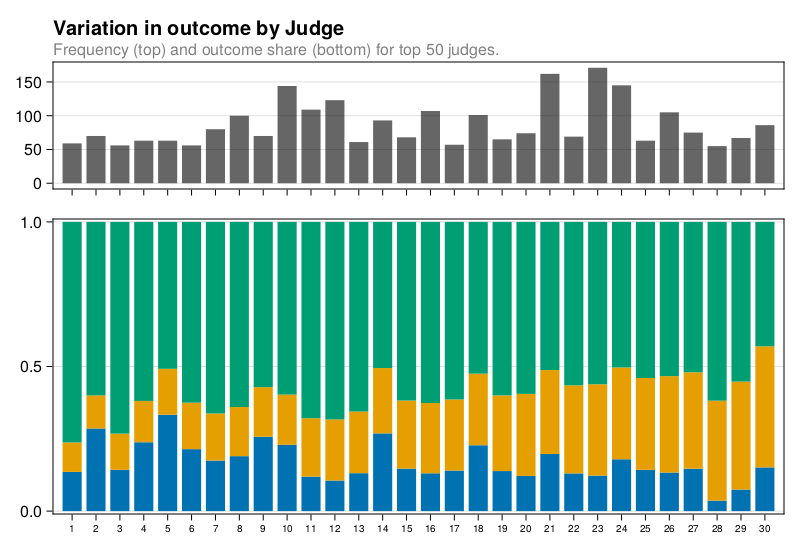

In [5]:
let df = flatten_and_summarize(decisions, judges)
    title = "Variation in outcome by Judge"
    subtitle = "Frequency (top) and outcome share (bottom) for top 50 judges."
    fig = plot_outcome_judge(df; title, subtitle)
    save("variation_judges.png", fig; px_per_unit=2)
    fig
end

In [6]:
function plot_outcome_tech(df; title="", subtitle="")
    outcomes = ["claim dismissed" => "dismissed", 
                "partially annulled" => "partially annulled", 
                "annulled" => "annulled"]

    dftop = first(rename(@rsubset(df, :group != "Y10"), outcomes), 30)
    dflong = DataFrames.stack(dftop, last.(outcomes))
    dflong.counts = dflong.value .* dflong.n

    order = sort!(dftop, :dismissed).group
    N = length(order)

    fig = Figure(resolution=(800, 650))

    pl1 = data(unique(dflong, [:group, :n])) * mapping(
            :group => sorter(order) => "", :n => "";
          ) * visual(BarPlot)

    axis = (;xticklabelsvisible=false, xgridvisible=false, 
            title, subtitle, titlealign=:left, titlesize=20, subtitlecolor=:grey50)

    gr1 = draw!(fig[1,1], pl1; axis)
    xlims!(0.2, N + 0.8)

    pl2 = data(dflong) * mapping(
            :group => sorter(order) => "", :value => ""; 
            stack=:variable, 
            color=:variable => ""
          ) * visual(BarPlot)

    ax2 = axis=(;xticklabelsize=10, xgridvisible=false)
      
    gr2 = draw!(fig[2,1], pl2;  axis=ax2)
    xlims!(0.2, N + 0.8); #ylims!(-0.01, 1.01)
    legend!(fig[3,1], gr2; tellwidth=false, tellheight=true, orientation=:horizontal)

    rowsize!(fig.layout, 1, Relative(.3))
    
    fig
end;

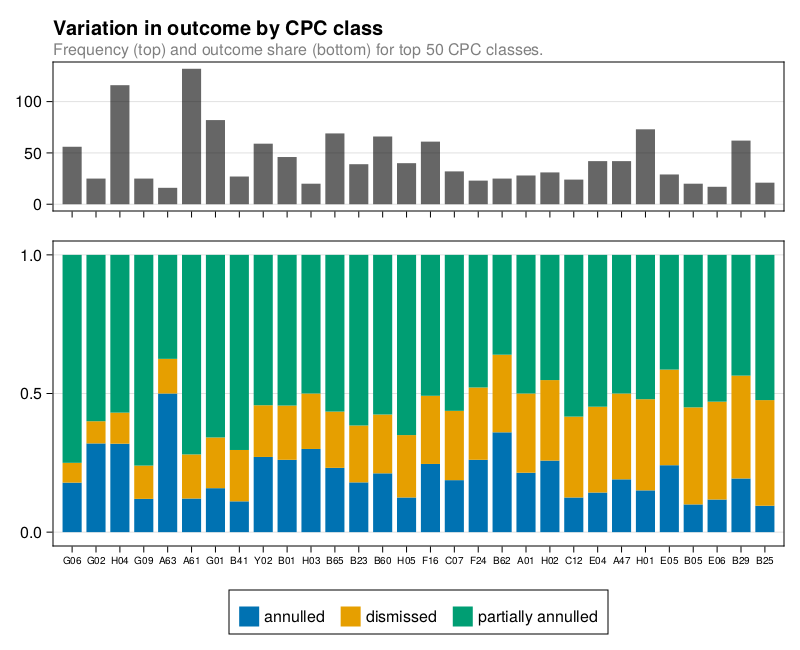

In [7]:
let df = flatten_and_summarize(decisions, class ∘ patent)
    title = "Variation in outcome by CPC class" 
    subtitle = "Frequency (top) and outcome share (bottom) for top 50 CPC classes."
    fig = plot_outcome_tech(df; title, subtitle)
    save("variation_tech.png", fig; px_per_unit=2)
    fig
end